In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import itertools

import tokenize_uk

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.utils import resample

from common import *

In [2]:
df = pd.read_json('reviews.json')

In [3]:
for n, g in df.groupby(['stars']):
    print('Class:', n, 'length:', len(g))

Class: 1 length: 2305
Class: 2 length: 2304
Class: 3 length: 4676
Class: 4 length: 15051
Class: 5 length: 42405


#### Preprocessing data 
- join paragraphs
- lowercase everything 

In [4]:
df['text'] = df['text'].apply(lambda x: ' '.join(x).lower())

In [5]:
df.head(20)

,stars,text
0,5,компьютерная марка lenovo известна своими дост...
1,5,вопрос к представителю:. можно ли надеяться на...
2,5,очень хорошая рабочая шустрая лошадка с приятн...
3,5,сбалансированные характеристики у планшета. дл...
4,5,"чудовий планшет, дружина використовує завжди з..."
5,4,користуюсь більше місяця. звичайно є недоліки...
6,3,планшет покупался для работы с текстами в доро...
7,5,майнкрафт на минимальных настройках графики по...
8,5,adobe p и adobe i как пойдут?
9,3,існують питання до якості картриджа недостатки...


#### Partitioning data into train/validation
Train is later used for cross-validation 

In [6]:
X, y = df['text'].values, df['stars'].values

partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

X, X_val, y, y_val = X[train_indexes], X[val_indexes], y[train_indexes], y[val_indexes]

for cls in np.sort(np.unique(y)):
    print('Train Class {}: {} examples'.format(cls, len(y[y == cls])))
    print('Validation Class {}: {} examples'.format(cls, len(y_val[y_val == cls])))
    
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

Train Class 1: 1844 examples
Validation Class 1: 461 examples
Train Class 2: 1843 examples
Validation Class 2: 461 examples
Train Class 3: 3741 examples
Validation Class 3: 935 examples
Train Class 4: 12041 examples
Validation Class 4: 3010 examples
Train Class 5: 33923 examples
Validation Class 5: 8482 examples


#### Creating learning pipeline with RandomForestClassifier and BOW without any text preprocessing

In [7]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.9858520485332457
Train score:  0.9866366925950905
Train score:  0.9857072261059283
Test CV score: 0.5752050881549704
Validation score: 0.5830648125978557


#### Confusion matrix for RF with BOW

[[  30   13   32  100  286]
 [  23   20   38  145  235]
 [  13   20   60  337  505]
 [  18   15   90  865 2022]
 [  31   18   81  929 7423]]


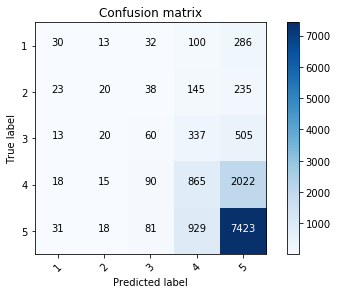

In [8]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [9]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.26      0.07      0.10       461
          2       0.23      0.04      0.07       461
          3       0.20      0.06      0.10       935
          4       0.36      0.29      0.32      3010
          5       0.71      0.88      0.78      8482

avg / total       0.56      0.63      0.58     13349



As we can see from above reports, due to imbalanced classes (42k in 5th class vs 2k in 1th and 2nd classes), 
majority class is predicted with f1_score = 0.78, whereas f1_score for 1st and 2nd classes eq 0.11 and 0.08 respectively.

#### Creating learning pipeline with RandomForestClassifier and TF-IDF without any text preprocessing

In [10]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = TfidfVectorizer()
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = TfidfVectorizer()
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9850944959489676


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9853570498680169


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.985864381999595
Test CV score: 0.5531168071110484


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Validation score: 0.5544034130048505


[[  36   13   22   59  331]
 [  18   11   26   81  325]
 [  19   11   20  189  696]
 [  17   10   46  438 2499]
 [   7    5   25  464 7981]]


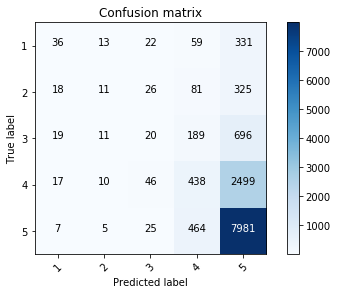

In [11]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [12]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.37      0.08      0.13       461
          2       0.22      0.02      0.04       461
          3       0.14      0.02      0.04       935
          4       0.36      0.15      0.21      3010
          5       0.67      0.94      0.79      8482

avg / total       0.54      0.64      0.55     13349



Similar situation with TF-IDF, so the problem is in fact that classes are imbalanced, not feature extraction method (for now)

### Resampling dataset to make it balanced

Min class is `1` and `2` so downlsampling other to their length

In [13]:
df_minority = df[df['stars'] == 1]
df_2 = df[df['stars'] == 2] # no downsampling here as it is small enough

df_3 = df[df['stars'] == 3]
df_4 = df[df['stars'] == 4]
df_5 = df[df['stars'] == 5]

df_3_downsampled = resample(df_3, replace=False, n_samples=len(df_minority), random_state=1234)
df_4_downsampled = resample(df_4, replace=False, n_samples=len(df_minority), random_state=1234)
df_5_downsampled = resample(df_5, replace=False, n_samples=len(df_minority), random_state=1234)

df_downsampled = pd.concat([df_minority, df_2, df_3_downsampled, df_4_downsampled, df_5_downsampled])

for n, g in df_downsampled.groupby(['stars']):
    print('Class:', n, 'length:', len(g))

Class: 1 length: 2305
Class: 2 length: 2304
Class: 3 length: 2305
Class: 4 length: 2305
Class: 5 length: 2305


In [14]:
X, y = df_downsampled['text'].values, df_downsampled['stars'].values

partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

X, X_val, y, y_val = X[train_indexes], X[val_indexes], y[train_indexes], y[val_indexes]

#### Creating RF + BOW pipeline on downsampled data

In [15]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.9864877079532376
Train score:  0.9887667633207503
Train score:  0.9856879860443863
Test CV score: 0.35140227449469147
Validation score: 0.34636249003491865


[[235 105  62  24  35]
 [155 129  89  57  31]
 [ 98 118 120  72  53]
 [ 56  74  96 125 110]
 [ 49  36  72 107 197]]


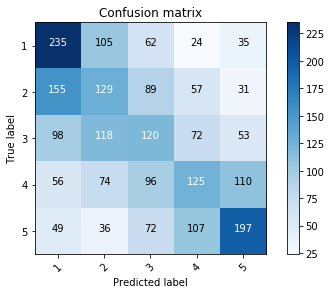

In [16]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [17]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.40      0.51      0.45       461
          2       0.28      0.28      0.28       461
          3       0.27      0.26      0.27       461
          4       0.32      0.27      0.30       461
          5       0.46      0.43      0.44       461

avg / total       0.35      0.35      0.35      2305



Overal validation score dropped drammatically to ~0.35
Although, from confusion matrix that classes 1, 2 (and a bit less 3) are confused between each other very often. 
From classification report we can see that f1_scores/precision/recall became a bit more equally distributed. 

#### RF + TF-IDF on balanced classes

In [18]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = TfidfVectorizer()
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = TfidfVectorizer()
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9899124312651605


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9905600199686642


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.991543485708585
Test CV score: 0.32873722965270685


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Validation score: 0.36095040174237236


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[[256  93  50  38  24]
 [151 134  96  58  22]
 [114  95 111 108  33]
 [ 54  71  95 145  96]
 [ 55  40  44 128 194]]


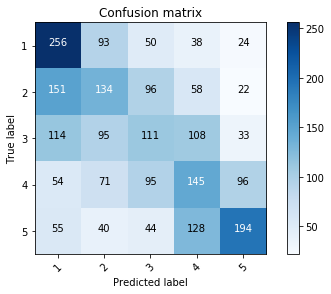

In [19]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [20]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.41      0.56      0.47       461
          2       0.31      0.29      0.30       461
          3       0.28      0.24      0.26       461
          4       0.30      0.31      0.31       461
          5       0.53      0.42      0.47       461

avg / total       0.37      0.36      0.36      2305



Same here. It is obvious now - we need better feature extraction method. First line attack with ignoring language, numbers, stopwords and other didn't work out. 

Further investigations are in separate notebook. 